# ClearMap2 parameter sweep on annotated volumes

The goal of this notebook is to perform a parameter sweep on a folder of tiff files that users have annotated and saved those annotations as RoiSet.zip files. If you have already turned these tiffs into stitched volumes, there's an option for that.

## Set up directories and imports

In [1]:
# imports 
import os,sys,json,glob,shutil
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
import pandas as pd
import seaborn as sns
from scipy.spatial import distance


In [35]:
path_to_cm2 = '/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe/ClearMap2'
src = '/home/emilyjanedennis/Desktop/'
ann_folder = os.path.join(src,'brains/cm2_train')
sys.path.append(path_to_cm2)

## Define functions

In [3]:
def convert_tiff_to_npy(src,ann_folder,this_ann_folder):
    file_loc = os.path.join(src,ann_folder,this_ann_folder)
    imported_tiff = tif.imread(file_loc)
    np.save(file_loc[0:-4] + '.npy',imported_tiff)

In [4]:
def get_ann_vals_in_np(src, ann_folder,ann_file):
    ann_vals=[]
    these_anns = os.listdir(os.path.join(src,ann_folder,ann_file))
    for j in np.arange(0,len(these_anns)):
        z = int(these_anns[j][0:4])
        y = int(these_anns[j][5:9])
        x = int(these_anns[j][10:14])
        ann_vals.append([z,y,x])
    return ann_vals

In [5]:
def pairwise_distance_metrics_given_cdists(
        ground_truth, predicted, y, cutoff=10, verbose=True):
    """
    Function to calculate the pairwise distances
    between two lists of zyx points.

    Inputs:
    -------
    ground_truth, predicted: each iterable
    consisting of ndimensional coordinates.
    y: matrix of distances between all
    elements of ground truth and predicted

    Returns:
    -------
    paired: list of [ground_truth"s index
    (from input list), predicted"s index (from input list), distance]
    tp,fp,fn: statistics on true positives,
    false positives, and false negatives.
    """
    # only keep those distances that are below the cutoff!
    truth_indices, pred_indices = np.where(y <= cutoff)
    dists = zip(y[truth_indices, pred_indices], truth_indices, pred_indices)

    # sort by smallest dist
    dists = sorted(dists, key=lambda x: x[0])

    used_truth = set()
    used_pred = set()
    paired = []
    for (i, dist) in enumerate(dists):
        d = dist[0]
        if d > cutoff:
            # we have reached distances beyond the cutoff
            break
        truth_idx = dist[1]
        pred_idx = dist[2]
        if truth_idx not in used_truth and pred_idx not in used_pred:
            paired.append((truth_idx, pred_idx, d))
            used_truth.add(truth_idx)
            used_pred.add(pred_idx)
        if len(used_truth) == len(ground_truth) or len(used_pred) == len(predicted):
            # we have used up all the entries from the shorter list
            break

    tp = len(paired)
    fn = len(ground_truth) - len(paired)
    fp = len(predicted) - len(paired)
    if verbose:
        print("TP: {}, FP: {}, FN: {}".format(tp, fp, fn))
    # print(paired)

    if verbose:
       plt.hist([xx[2] for xx in paired], bins=np.max((int(len(paired)/500), 10)))
       plt.title("Histogram of distances - pixel or microns")

    return paired, tp, fp, fn

In [6]:
def filter_cells(source, thresholds):
  """Filter a array of detected cells according to the thresholds.
  
  Arguments
  ---------
  source : str, array or Source
    The source for the cell data.
  sink : str, array or Source
    The sink for the results.
  thresholds : dict
    Dictionary of the form {name : threshold} where name refers to the 
    column in the cell data and threshold can be None, a float 
    indicating a minimal threshold or a tuple (min,max) where min,max can be
    None or a minimal and maximal threshold value.
  
  Returns
  -------
  sink : str, array or Source
    The thresholded cell data.
  """
  
  ids = np.ones(source.shape[0], dtype=bool);
  for k,t in thresholds.items():
    if t:
      if not isinstance(t, (tuple, list)):
        t = (t, None);
      if t[0] is not None:
        ids = np.logical_and(ids, t[0] <= source[k])
      if t[1] is not None:
        ids = np.logical_and(ids, t[1] > source[k]);
  cells_filtered = source[ids];
  return cells_filtered


In [7]:
def pairwise_distance_metrics(ground_truth, predicted, cutoff=10, verbose=True):
    """
    Function to calculate the pairwise distances
    between two lists of zyx points.

    Inputs:
    -------
    ground_truth, predicted: each iterable consisting of
    ndimensional coordinates.

    Returns:
    -------
    paired: list of [ground_truth"s index (from input list),
    predicted"s index (from input list), distance]
    tp,fp,fn: statistics on true positives, false positives,
    and false negatives.
    """

    if verbose:
        print("\nCalculating pairwise distances...")
    y = distance.cdist(ground_truth, predicted, metric="euclidean")
    return pairwise_distance_metrics_given_cdists(
       ground_truth, predicted, y, cutoff, verbose)

## Prepare data for cm2

In [ ]:
# if you need to make .npy files from tiffs:
listoftiffs = [f for f in os.listdir(ann_folder) if f.find('.tif') != -1]
for i in np.arange(0,len(listoftiffs)):
    convert_tiff_to_npy(src,ann_folder,listoftiffs[i])

In [39]:
listofanns = [f for f in os.listdir(ann_folder) if f.find('.RoiSet') != -1]
listofnpys = [f for f in os.listdir(ann_folder) if f.find('.npy') != -1]

In [40]:
listofnpys

['z269stackstart150_ejd_img_raw_bck5_shpthresh300.npy',
 'z266stackstart400_set2_img_raw_bck5_shpthresh300.npy',
 'z266stackstart180_set2_ejd_img_raw_bck5_shpthresh300.npy',
 'z266stackstart250_img_raw_bck5_shpthresh300.npy',
 'z266stackstart420_set2_ejd_img_raw_bck5_shpthresh300.npy',
 'z266stackstart350_img_raw_bck5_shpthresh300.npy',
 'z268stackstart310_set2_ejd_img_raw_bck5_shpthresh300.npy',
 'z269stackstart500_set2_ejd_img_raw_bck5_shpthresh300.npy',
 'z266stackstart150_img_raw_bck5_shpthresh300.npy',
 'z269stackstart400_ejd_img_raw_bck5_shpthresh300.npy',
 'z269stackstart475_ejd_img_raw_bck5_shpthresh300.npy',
 'z266stackstart350_ejd_img_raw_bck5_shpthresh300.npy',
 'z269stackstart100_ejd_img_raw_bck5_shpthresh300.npy',
 'z266stackstart400_set2_ejd_img_raw_bck5_shpthresh300.npy',
 'z266stackstart250_ejd_img_raw_bck5_shpthresh300.npy']

## Set up ClearMap2: imports and directories

In [9]:
import ClearMap.IO.Workspace as wsp
import ClearMap.IO.IO as io
import ClearMap.ImageProcessing.Experts.Cells as cells
from itertools import product

/home/emilyjanedennis/anaconda3/envs/cm2/lib/python3.6/site-packages/vispy/visuals/line/line.py:395: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('color', np.float32, 4)])
/home/emilyjanedennis/anaconda3/envs/cm2/lib/python3.6/site-packages/vispy/visuals/line/arrow.py:57: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('linewidth', np.float32, 1)
/home/emilyjanedennis/anaconda3/envs/cm2/lib/python3.6/site-packages/vispy/visuals/isocurve.py:22: UserWarning: VisPy is not yet compatible with matplotlib 2.2+
  warnings.warn("VisPy is not yet compatible with matplotlib 2.2+")


In [10]:
directory = ann_folder
ws = wsp.Workspace('CellMap', directory=directory);

## Define CM2 parameters to sweep over

In [14]:
# Here we list the parameter ranges to sweep over.
background_sizes = [3,5] # will make xy tuples like: (5,5), (7,7), (9,9)  
shape_threshold_sizes = [300,130]

In [15]:
# set up basic, shared cell_detection_parameters
cell_detection_parameter = cells.default_cell_detection_parameter.copy()
cell_detection_parameter['illumination'] = None
cell_detection_parameter['intensity_detection']['measure'] = ['source','background']

processing_parameter = cells.default_cell_detection_processing_parameter.copy()
processing_parameter.update(
    processes = 'serial',
    size_max = 100, #35,
    size_min = 30, #30,
    overlap  = 15, #10,
    verbose = True
    )

## CM2 Parameter sweep

In [16]:
for file in listofnpys:
    if file.find('bck') == -1:
        ws.update(stitched=file)
        ws.info()

        for background_size,shape_threshold_size in product(background_sizes,shape_threshold_sizes):
            this_cell_parameter_dict = cell_detection_parameter.copy()
            this_cell_parameter_dict['background_correction']['shape'] = (background_size,background_size)
            this_cell_parameter_dict['shape_detection']['threshold'] = shape_threshold_size
            postfix = f'raw_bck{background_size}_shpthresh{shape_threshold_size}'
            # actually detect cells:
            cells.detect_cells(ws.filename('stitched'),
                               ws.filename('stitched', postfix=postfix),
                               cell_detection_parameter=this_cell_parameter_dict,
                               processing_parameter=processing_parameter)

Workspace[CellMap]{/home/emilyjanedennis/Desktop/mesospim_anns}
              raw: no file
 autofluorescence: no file
         stitched: j319_642_2000-2400_1100-1500_1985-2010_stitched.npy
           layout: no file
       background: no file
        resampled: no file
resampled_to_auto: no file
auto_to_reference: no file
            cells: no file
          density: no file

Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (3, 3)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.032
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (3, 3)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.013
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: elapsed time: 0:00:00.000
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.214
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (3, 3)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.047
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Cell detection: elapsed time: 0:00:00.166
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.263
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.211
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.012
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: elapsed time: 0:00:00.000
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.045
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Cell detection: elapsed time: 0:00:00.140
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.236
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (3, 3)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.207
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (3, 3)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.211
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (3, 3)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Find Maxima: elapsed time: 0:00:00.025
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Maxima detection: elapsed time: 0:00:00.039
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: threshold: 300
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: save     : False
Shape detection threshold: 300
Shape detection: elapsed time: 0:00:00.020
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.030
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Intensity detection: method: max
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Intensity detection: shape : 3
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.043
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Cell detection: elapsed time: 0:00:00.128
P

Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Shape detection: elapsed time: 0:00:00.044
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Cell detection: elapsed time: 0:00:00.148
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.244
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0

Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Shape detection: elapsed time: 0:00:00.058
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Cell detection: elapsed time: 0:00:00.139
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.238
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.012
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0

Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.021
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma2: None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: elapsed time: 0:00:00.000
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Maxima detection: h_max    : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Maxima detection: shape    : 5
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Maxima detection: threshold: 0
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Maxima detection: valid    : True
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25,

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.215
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (3, 3)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.261
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (3, 3)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:01.519
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.011
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma2: None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.210
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.012
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: elapsed time: 0:00:00.000
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.044
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Cell detection: elapsed time: 0:00:00.148
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.244
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (3, 3)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 

Find Maxima: elapsed time: 0:00:00.025
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Maxima detection: elapsed time: 0:00:00.028
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Shape detection: threshold: 300
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Shape detection: save     : False
Shape detection threshold: 300
Shape detection: elapsed time: 0:00:00.020
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Shape detection: elapsed time: 0:00:00.029
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Intensity detection: method: max
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Intensity detection: shape : 3
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Shape detection: elapsed time: 0:00:00.043
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Cell detection: ela

Find Maxima: elapsed time: 0:00:00.024
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Maxima detection: elapsed time: 0:00:00.027
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Shape detection: threshold: 130
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Shape detection: save     : False
Shape detection threshold: 130
Shape detection: elapsed time: 0:00:00.020
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Shape detection: elapsed time: 0:00:00.030
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Intensity detection: method: max
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Intensity detection: shape : 3
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Shape detection: elapsed time: 0:00:00.043
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Cell detection: ela

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.211
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.212
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:01.434
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.011
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.213
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.012
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.044
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Cell detection: elapsed time: 0:00:00.129
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.224
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (3, 3)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 

Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Cell detection: elapsed time: 0:00:00.126
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.220
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (3, 3)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)>

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.285
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (3, 3)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.211
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.209
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:01.429
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.019
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.230
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.044
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Cell detection: elapsed time: 0:00:00.141
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.236
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (3, 3)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.206
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (3, 3)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (3, 3)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.012
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: elapsed time: 0:00:00.000
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.044
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Cell detection: elapsed time: 0:00:00.156
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.251
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.012
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.210
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.012
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.012
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: elapsed time: 0:00:00.000
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.044
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Cell detection: elapsed time: 0:00:00.138
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.234
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (3, 3)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.012
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 

Find Maxima: elapsed time: 0:00:00.024
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Maxima detection: elapsed time: 0:00:00.027
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Shape detection: threshold: 300
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Shape detection: save     : False
Shape detection threshold: 300
Shape detection: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Shape detection: elapsed time: 0:00:00.027
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Intensity detection: method: max
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Intensity detection: shape : 3
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Shape detection: elapsed time: 0:00:00.043
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Cell detection: ela

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: elapsed time: 0:00:00.211
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal shape: (3, 3)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.012
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.214
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.012
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: elapsed time: 0:00:00.210
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:01.435
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.012
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: elapsed time: 0:00:00.213
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.012
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(2

Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.072
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Cell detection: elapsed time: 0:00:00.182
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.285
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (3, 3)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.012
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.209
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (3, 3)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.224
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (3, 3)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.012
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.044
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Cell detection: elapsed time: 0:00:00.119
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.220
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.012
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.214
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.012
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.222
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.012
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.068
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Cell detection: elapsed time: 0:00:00.164
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.267
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (3, 3)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.018
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.216
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (3, 3)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.012
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.267
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (3, 3)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.012
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Find Maxima: elapsed time: 0:00:00.026
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Maxima detection: elapsed time: 0:00:00.031
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: threshold: 300
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: save     : False
Shape detection threshold: 300
Shape detection: elapsed time: 0:00:00.032
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.042
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Intensity detection: method: max
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Intensity detection: shape : 3
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Shape detection: elapsed time: 0:00:00.044
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Cell detection: elapsed time: 0:00:00.133
P

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.209
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.012
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Find Maxima: elapsed time: 0:00:00.025
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Maxima detection: elapsed time: 0:00:00.052
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Shape detection: threshold: 130
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Shape detection: save     : False
Shape detection threshold: 130
Shape detection: elapsed time: 0:00:00.020
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Shape detection: elapsed time: 0:00:00.029
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Intensity detection: method: max
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Intensity detection: shape : 3
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Shape detection: elapsed time: 0:00:00.043
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Cell detection: ela

## Calculate fp, fn, precision for each volume, save as data frame

In [42]:
list_of_vals = []
chval = 'shpthresh'
filt_srcs = [2,3]
filt_tup_starts = [1,2,4,6,8,10,20,30]
filt_tup_ends = [100,120,140,160,200,250,300,400]
all_tups = []
for i in np.arange(0,len(filt_tup_starts)):
    for j in np.arange(0,len(filt_tup_ends)):
        all_tups.append((filt_tup_starts[i],filt_tup_ends[j]))

for i in np.arange(0,len(listofnpys)):
    base_filename = listofnpys[i][0:-4]
    if base_filename.find(chval) != -1:
        print(base_filename)
        sweep_list = [f for f in os.listdir(ann_folder) if np.all(f.find('shpthresh') != -1 and f.find(base_filename) != -1)]
        for j in np.arange(0,len(sweep_list)):
            print('{} of {}'.format(j,len(sweep_list)))
            for k in filt_srcs:
                print(k)
                sweep_cells = np.load(os.path.join(ann_folder,sweep_list[j]))
                for ll in np.arange(0,len(all_tups)):
                    filt_vals = all_tups[ll]
                    filt_params = str('{}_{}_{}'.format(k,filt_vals[0],filt_vals[1]))
                    thresholds = {'source' : k,'size'   : filt_vals}
                    filetosave= os.path.join(ann_folder,"{}_{}_filtered.npy".format(sweep_list[j][:-4],filt_params))
                    cells.filter_cells(source = sweep_cells,
                                        sink = filetosave,
                                        thresholds=thresholds)
                    
                    filtered_cells = pd.DataFrame(np.load(filetosave))
                    paired, tp, fp, fn = pairwise_distance_metrics(ann_vals,filtered_cells[['x','y','z']],cutoff=30,verbose=False)
                    if tp+fp > 0:
                        precision = tp/(tp+fp)
                        recall = tp/(tp+fn)
                        f1 = 2*((precision*recall)/(precision+recall))
                    else:
                        precision = 0
                        recall = 0
                        f1=0
                    list_of_vals.append([base_filename,sweep_list[j][-19:-17],sweep_list[j][-7:-4],filt_params,tp,fp,fn,precision,recall,f1])
pd_to_save = pd.DataFrame(list_of_vals,columns=['all','bck','shpthresh','filt_params','tp','fp','fn','precision','recall','f1'])
save_name = os.path.join(ann_folder,'ALL_withfilt_{}_sweep_RESULTS.csv'.format(chval))
pd_to_save.to_csv(save_name)
pd_642_orig=pd_to_save

z269stackstart150_ejd_img_raw_bck5_shpthresh300
0 of 1
2
3
z266stackstart400_set2_img_raw_bck5_shpthresh300
0 of 1
2
3
z266stackstart180_set2_ejd_img_raw_bck5_shpthresh300
0 of 1
2
3
z266stackstart250_img_raw_bck5_shpthresh300
0 of 1
2
3
z266stackstart420_set2_ejd_img_raw_bck5_shpthresh300
0 of 1
2
3
z266stackstart350_img_raw_bck5_shpthresh300
0 of 1
2
3
z268stackstart310_set2_ejd_img_raw_bck5_shpthresh300
0 of 1
2
3
z269stackstart500_set2_ejd_img_raw_bck5_shpthresh300
0 of 1
2
3
z266stackstart150_img_raw_bck5_shpthresh300
0 of 1
2
3
z269stackstart400_ejd_img_raw_bck5_shpthresh300
0 of 1
2
3
z269stackstart475_ejd_img_raw_bck5_shpthresh300
0 of 1
2
3
z266stackstart350_ejd_img_raw_bck5_shpthresh300
0 of 1
2
3
z269stackstart100_ejd_img_raw_bck5_shpthresh300
0 of 1
2
3
z266stackstart400_set2_ejd_img_raw_bck5_shpthresh300
0 of 1
2
3
z266stackstart250_ejd_img_raw_bck5_shpthresh300
0 of 1
2
3


In [45]:
ann_folder

'/home/emilyjanedennis/Desktop/brains/cm2_train'

In [128]:
pd_488_orig = pd.read_csv('/home/emilyjanedennis/Desktop/mesospim_anns/ALL_488_sweep_RESULTS.csv')

In [131]:
pd_488 = pd_488_orig.copy()

pd_488['shpthresh']=pd_488['shpthresh'].astype('int')
pd_488['min_size']=pd_488['min_size'].astype('int')
pd_488= pd_488[pd_488['bck']=='k7']
pd_488 = pd_488[pd_488['shpthresh']>90]
pd_488 = pd_488[pd_488['shpthresh']<120]

pd_488 = pd_488[pd_488['min_size']==6]

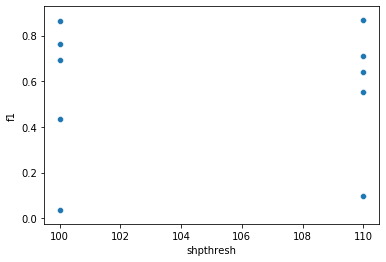

In [133]:
sns.scatterplot(data=pd_488,x='shpthresh',y='f1')
#plt.ylim([0.6,1])
#k5, 110,4 // 120-130,2
#k7, 110,6 // 120,4
#k9, 130,4 // 120,6 // 110,10
#11, 130,6 //120,10
#13, 130,8

In [145]:
pd_642 = pd_642_orig.copy()
pd_642['shpthresh']=pd_642['shpthresh'].astype('int')
pd_642['min_size']=pd_642['min_size'].astype('int')

pd_642 = pd_642[pd_642['shpthresh'] <160]
pd_642 = pd_642[pd_642['shpthresh'] >120]
pd_642 = pd_642[pd_642['bck']=='13']
pd_642=pd_642[pd_642['min_size']<12]
pd_642=pd_642[pd_642['min_size']>5]

(0.2, 0.8)

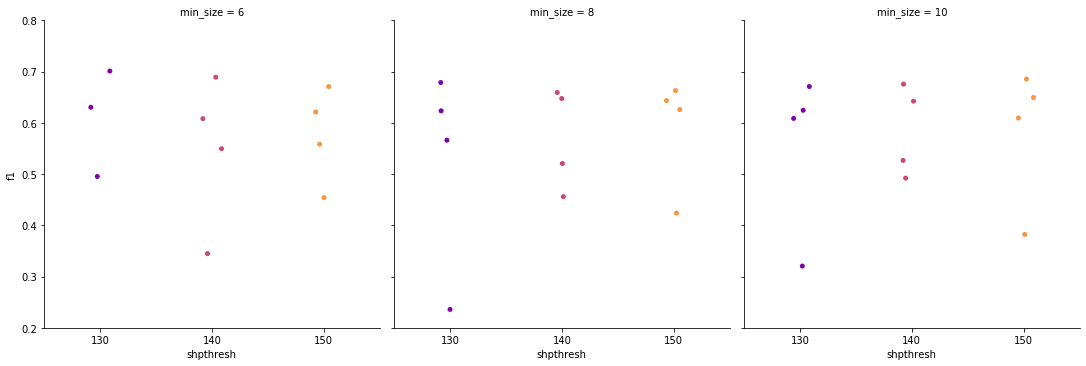

In [146]:
sns.catplot(data = pd_642,x='shpthresh',y='f1',col='min_size',palette='plasma')
plt.ylim([0.2,0.8])

In [112]:
#k5 130, 4
#k7 130 8
#k9 130,8
# 11, 150, 8
# 13, 150,8
eight = pd_642[pd_642['min_size']==8]
e5=eight[eight['bck']=='k5']
e7 = eight[eight['bck']=='k7']
e9 = eight[eight['bck']=='k9']
e11 = eight[eight['bck']=='11']
e13 = eight[eight['bck']=='13']

In [123]:
pd_642_orig=pd.read_csv('/home/emilyjanedennis/Desktop/mesospim_anns/ALL_642_sweep_RESULTS.csv')

In [149]:
testdf = pd_488_orig.groupby(['bck','shpthresh','min_size'])['f1','recall','precision'].agg(['sum','mean','median'])

/home/emilyjanedennis/anaconda3/envs/cm2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [151]:
testdf.to_csv('/home/emilyjanedennis/Desktop/488-2groupedmeans.csv')

In [125]:
pd_642_orig

,Unnamed: 0,all,bck,shpthresh,min_size,tp,fp,fn,precision,recall,f1
0,0,j319_642_2000-2400_1100-1500_1985-2010_stitched,k9,260,2,12,0,391,1.000000,0.029777,0.057831
1,1,j319_642_2000-2400_1100-1500_1985-2010_stitched,k9,260,4,9,0,394,1.000000,0.022333,0.043689
2,2,j319_642_2000-2400_1100-1500_1985-2010_stitched,k9,260,6,8,0,395,1.000000,0.019851,0.038929
3,3,j319_642_2000-2400_1100-1500_1985-2010_stitched,k9,260,8,8,0,395,1.000000,0.019851,0.038929
4,4,j319_642_2000-2400_1100-1500_1985-2010_stitched,k9,260,10,7,0,396,1.000000,0.017370,0.034146
...,...,...,...,...,...,...,...,...,...,...,...
1920,1920,j319_642_1000-1400_4600-5000_1790-1815_stitched,11,180,2,44,5,189,0.897959,0.188841,0.312057
1921,1921,j319_642_1000-1400_4600-5000_1790-1815_stitched,11,180,4,36,4,197,0.900000,0.154506,0.263736
1922,1922,j319_642_1000-1400_4600-5000_1790-1815_stitched,11,180,6,33,4,200,0.891892,0.141631,0.244444
1923,1923,j319_642_1000-1400_4600-5000_1790-1815_stitched,11,180,8,29,4,204,0.878788,0.124464,0.218045


In [ ]:
#13, 150, 8 for 642
#k7 110 6

In [8]:
cells = np.load('/Users/emilydennis/Desktop/cells_raw.npy')
np.shape(cells)

(32911977,)

In [14]:
celldf=pd.DataFrame(cells)

In [18]:
gt100=celldf.copy()
gt100 = gt100[gt100['size']>100]

In [ ]:
sns.scatterplot(data=gt100[gt100['size']<102],x='x',y='y',hue='z',legend=False,size=1,marker='.')

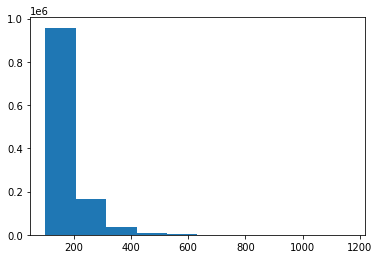

In [33]:
plt.hist(gt100['size'])
plt.show()